# ASL CNN Training Notebook
This notebook demonstrates how to preprocess ASL hand sign images using MediaPipe, train a CNN model, and export it to TensorFlow Lite format.

## 1. Install Required Libraries
Install all necessary libraries for preprocessing, model training, and conversion.

In [ ]:
# Install required packages (uncomment if running for the first time)
# !pip install mediapipe torch torchvision matplotlib numpy opencv-python scikit-learn onnx

## 2. Import Libraries
Import all required Python libraries.

In [1]:
import os
import numpy as np
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

## Check if CUDA (GPU) or CPU is being used
This cell will print whether PyTorch is using CUDA (GPU) or CPU for computations.

In [2]:
import torch

print("PyTorch is using:", "CUDA" if torch.cuda.is_available() else "CPU")
if torch.cuda.is_available():
    print("CUDA device name:", torch.cuda.get_device_name(0))
    print("PyTorch CUDA version:", torch.version.cuda)

PyTorch is using: CUDA
CUDA device name: NVIDIA GeForce RTX 3050 Laptop GPU
PyTorch CUDA version: 12.1


## 2. Load and Preprocess Dataset
Load images, preprocess them, and prepare data for training.

In [3]:
import numpy as np
import os
import cv2
from tqdm import tqdm

DATASET_PATH = '../datasets/asl/asl_alphabet_train/'
LABELS_PATH = '../labels/asl_labels.txt'

# Load class labels
with open(LABELS_PATH, 'r') as f:
    class_names = [line.strip() for line in f.readlines() if line.strip() and not line.startswith('#')]
num_classes = len(class_names)

X = []
y = []

image_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

for idx, class_name in enumerate(class_names):
    class_dir = os.path.join(DATASET_PATH, class_name)
    if not os.path.isdir(class_dir):
        print(f"Warning: Folder '{class_name}' not found in dataset. Skipping.")
        continue
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(image_extensions)]
    for img_name in tqdm(image_files, desc=f"Processing {class_name}"):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (64, 64))  # or (128, 128) if you prefer
            X.append(img)
            y.append(idx)

X = np.array(X)
y = np.array(y)
X = X / 255.0
print(f"Dataset shape: {X.shape}, Labels shape: {y.shape}")

Processing space: 100%|███████████████████████████████████████████████████████████| 3000/3000 [00:14<00:00, 204.14it/s]


Dataset shape: (87000, 64, 64, 3), Labels shape: (87000,)


## 3. Train/Validation Split (70/30)
Split the dataset into 70% training and 30% validation sets using scikit-learn.

In [4]:
# 5. Train/Validation Split and DataLoaders
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Convert to PyTorch tensors
X_train_ten = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2) if X_train.ndim == 4 else torch.tensor(X_train, dtype=torch.float32)
y_train_ten = torch.tensor(y_train, dtype=torch.long)
X_val_ten = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2) if X_val.ndim == 4 else torch.tensor(X_val, dtype=torch.float32)
y_val_ten = torch.tensor(y_val, dtype=torch.long)

train_load = DataLoader(TensorDataset(X_train_ten, y_train_ten), batch_size=32, shuffle=True)
val_load = DataLoader(TensorDataset(X_val_ten, y_val_ten), batch_size=32)

print(f"Train set: {len(train_load.dataset)} samples")
print(f"Validation set: {len(val_load.dataset)} samples")

X_full_ten = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2) if X.ndim == 4 else torch.tensor(X, dtype=torch.float32)
y_full_ten = torch.tensor(y, dtype=torch.long)
full_load = DataLoader(TensorDataset(X_full_ten, y_full_ten), batch_size=32, shuffle=True)

print(f"Full training set: {len(full_load.dataset)} samples")

Train set: 60900 samples
Validation set: 26100 samples
Full training set: 87000 samples


In [5]:
# Example PyTorch CNN model (replace/expand as needed)
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)  # Global average pooling
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, val_loader=None, epochs=50, lr=0.0002, save_path='best_model.pth'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == y_batch).sum().item()
        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)

        # Validation (if provided)
        if val_loader is not None:
            model.eval()
            val_loss = 0
            val_correct = 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    val_loss += loss.item() * X_batch.size(0)
                    _, preds = torch.max(outputs, 1)
                    val_correct += (preds == y_batch).sum().item()
            val_loss /= len(val_loader.dataset)
            val_acc = val_correct / len(val_loader.dataset)
            scheduler.step(val_loss)

            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), save_path)
        else:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    if val_loader is not None:
        print(f"Best validation loss: {best_val_loss:.4f}. Model saved to {save_path}")
    return model

In [8]:
simple_cnn = SimpleCNN(num_classes)
simple_cnn = train_model(simple_cnn, train_load, val_load, epochs=150, lr=0.0002)

Epoch 1/150 | Train Loss: 2.0494 | Train Acc: 0.4626 | Val Loss: 1.2040 | Val Acc: 0.7067
Epoch 2/150 | Train Loss: 0.9824 | Train Acc: 0.7494 | Val Loss: 0.6370 | Val Acc: 0.8540
Epoch 3/150 | Train Loss: 0.5988 | Train Acc: 0.8479 | Val Loss: 1.6381 | Val Acc: 0.5122
Epoch 4/150 | Train Loss: 0.4198 | Train Acc: 0.8916 | Val Loss: 0.3109 | Val Acc: 0.9211
Epoch 5/150 | Train Loss: 0.3167 | Train Acc: 0.9191 | Val Loss: 0.4189 | Val Acc: 0.8516
Epoch 6/150 | Train Loss: 0.2497 | Train Acc: 0.9358 | Val Loss: 0.7407 | Val Acc: 0.7311
Epoch 7/150 | Train Loss: 0.2052 | Train Acc: 0.9473 | Val Loss: 0.2385 | Val Acc: 0.9244
Epoch 8/150 | Train Loss: 0.1732 | Train Acc: 0.9560 | Val Loss: 1.3565 | Val Acc: 0.6233
Epoch 9/150 | Train Loss: 0.1499 | Train Acc: 0.9623 | Val Loss: 1.2282 | Val Acc: 0.6566
Epoch 10/150 | Train Loss: 0.1390 | Train Acc: 0.9637 | Val Loss: 0.2263 | Val Acc: 0.9222
Epoch 11/150 | Train Loss: 0.1140 | Train Acc: 0.9724 | Val Loss: 0.1162 | Val Acc: 0.9668
Epoch 12

In [11]:
simple_cnn = SimpleCNN(num_classes)
simple_cnn.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
simple_cnn = train_model(simple_cnn, full_load, epochs=50, lr=0.0002)

C:\Users\Sahil\AppData\Local\Temp\ipykernel_14476\502756128.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simple_cnn.load_state_dict(torch.load('best_model.pth', map_l

Epoch 1/50 | Train Loss: 0.0182 | Train Acc: 0.9984
Epoch 2/50 | Train Loss: 0.0159 | Train Acc: 0.9985
Epoch 3/50 | Train Loss: 0.0152 | Train Acc: 0.9985
Epoch 4/50 | Train Loss: 0.0140 | Train Acc: 0.9987
Epoch 5/50 | Train Loss: 0.0144 | Train Acc: 0.9984
Epoch 6/50 | Train Loss: 0.0126 | Train Acc: 0.9988
Epoch 7/50 | Train Loss: 0.0115 | Train Acc: 0.9990
Epoch 8/50 | Train Loss: 0.0131 | Train Acc: 0.9987
Epoch 9/50 | Train Loss: 0.0122 | Train Acc: 0.9989
Epoch 10/50 | Train Loss: 0.0135 | Train Acc: 0.9987
Epoch 11/50 | Train Loss: 0.0117 | Train Acc: 0.9992
Epoch 12/50 | Train Loss: 0.0111 | Train Acc: 0.9991
Epoch 13/50 | Train Loss: 0.0127 | Train Acc: 0.9986
Epoch 14/50 | Train Loss: 0.0118 | Train Acc: 0.9989
Epoch 15/50 | Train Loss: 0.0102 | Train Acc: 0.9993
Epoch 16/50 | Train Loss: 0.0119 | Train Acc: 0.9990
Epoch 17/50 | Train Loss: 0.0108 | Train Acc: 0.9991
Epoch 18/50 | Train Loss: 0.0120 | Train Acc: 0.9989
Epoch 19/50 | Train Loss: 0.0103 | Train Acc: 0.9991
Ep

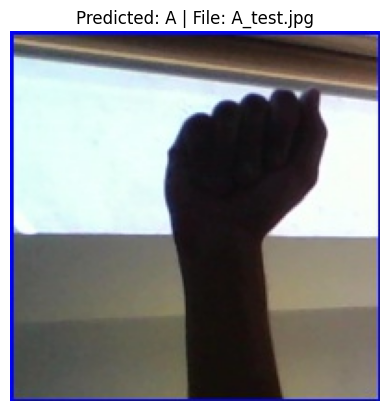

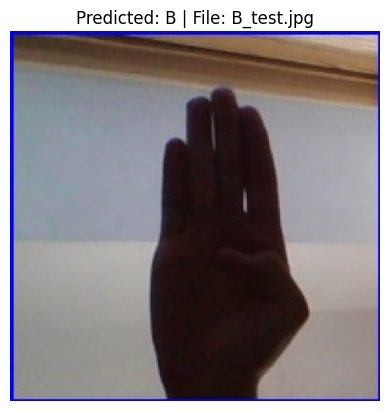

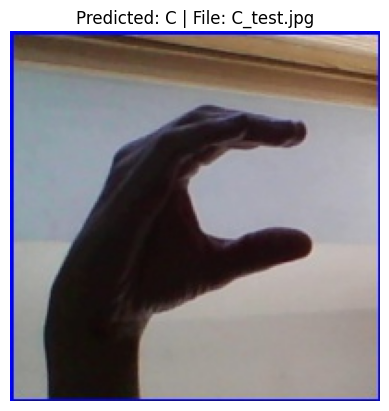

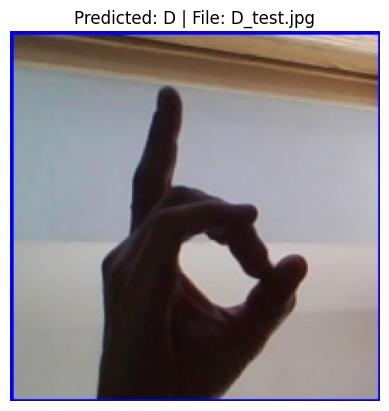

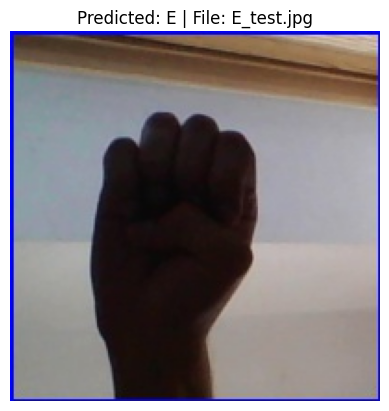

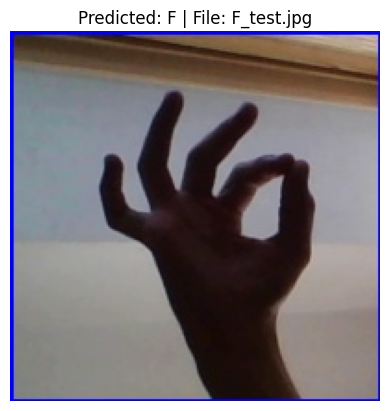

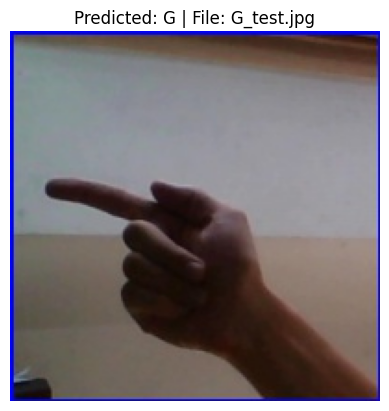

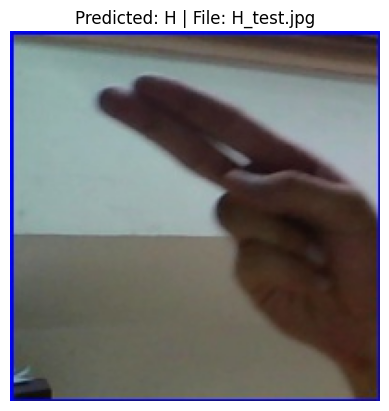

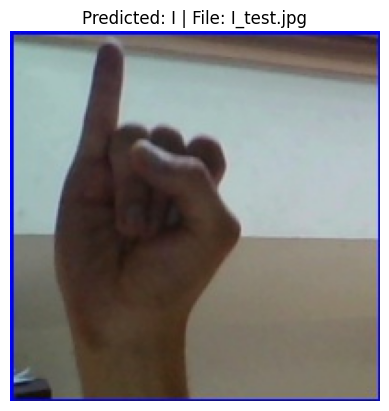

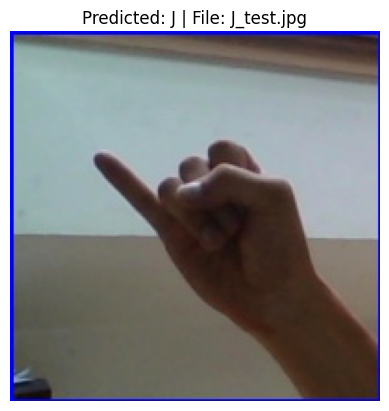

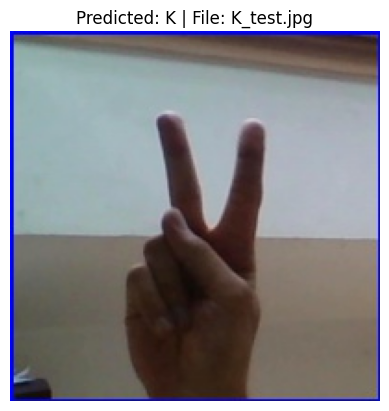

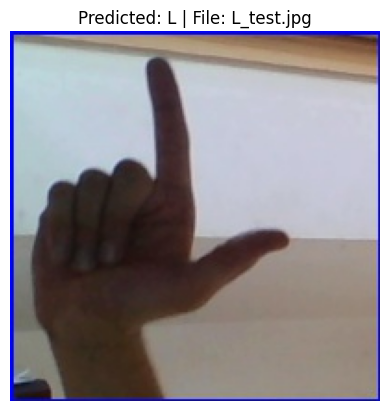

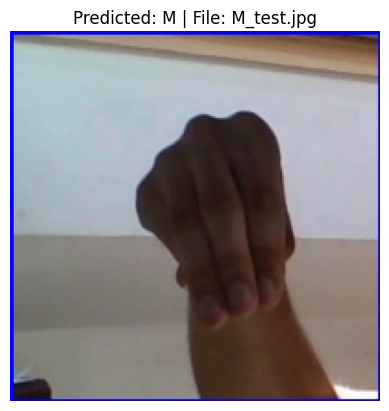

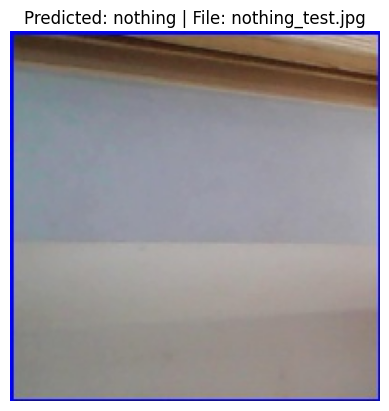

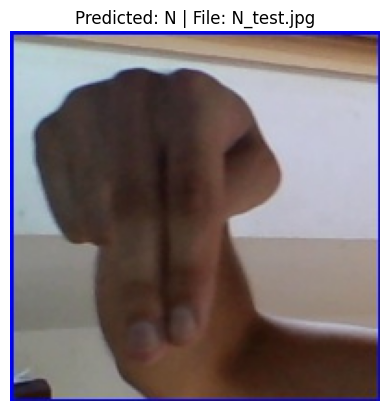

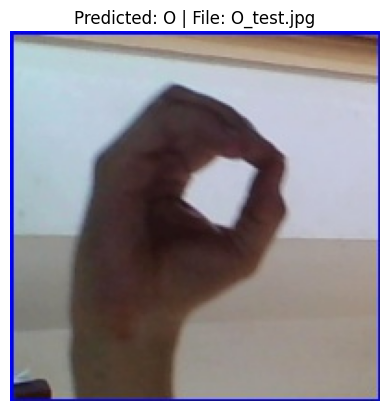

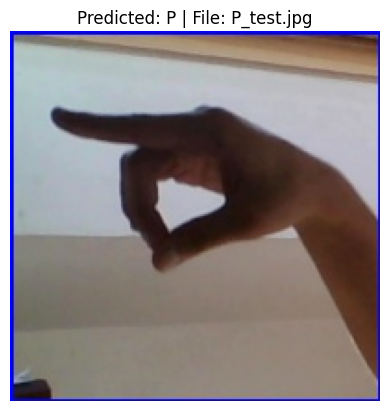

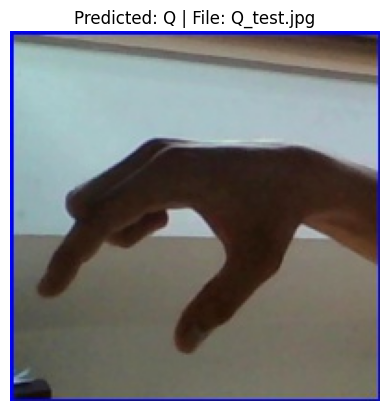

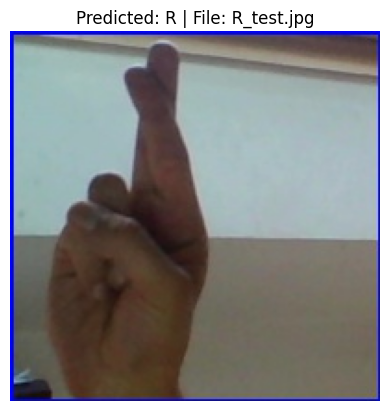

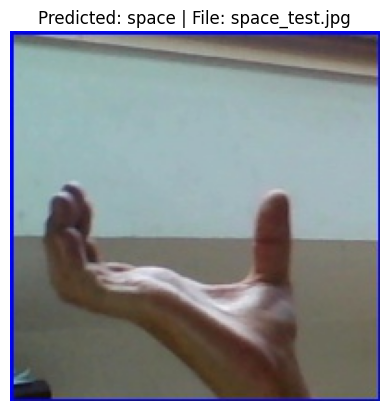

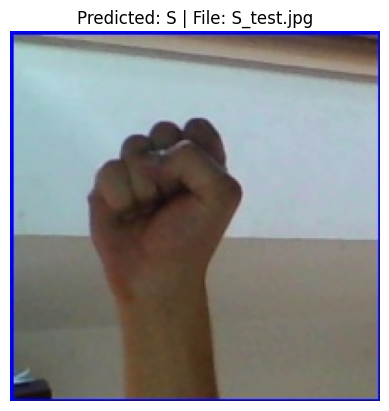

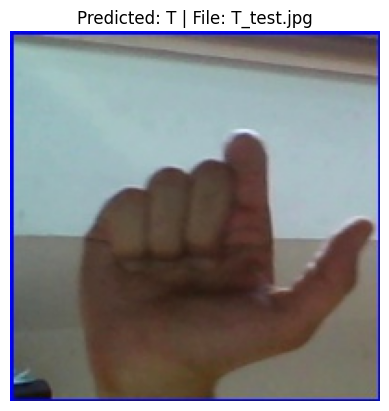

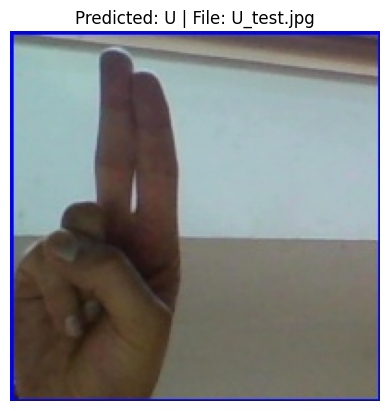

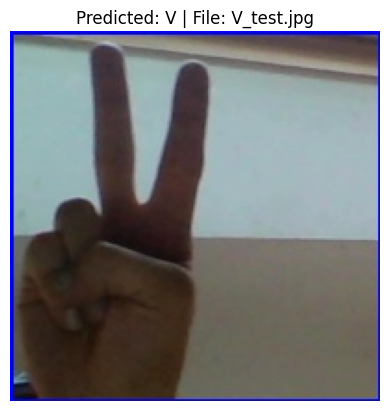

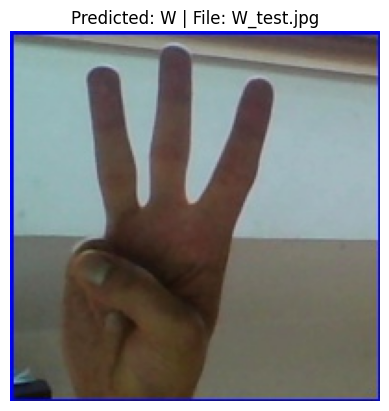

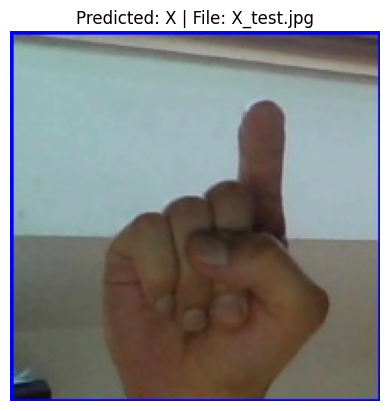

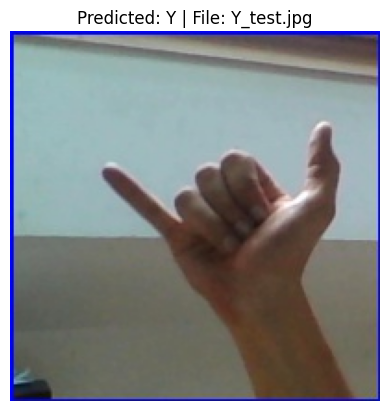

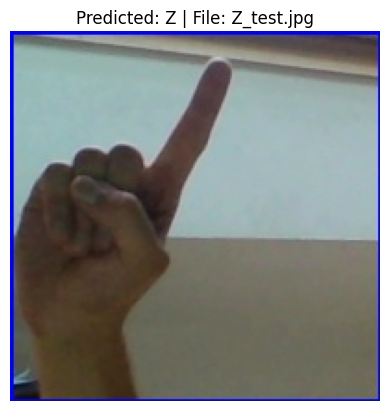

In [13]:
import cv2
import matplotlib.pyplot as plt
import torch

# Set test folder path
TEST_PATH = '../datasets/asl/asl_alphabet_test/'

# Load class labels
with open('../labels/asl_labels.txt', 'r') as f:
    class_names = [line.strip() for line in f.readlines() if line.strip() and not line.startswith('#')]

# Set model to eval mode and move to device
simple_cnn.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simple_cnn = simple_cnn.to(device)

# Helper: preprocess test image (match your training preprocessing)
def preprocess_test_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # If you used mediapipe_hand_crop for training, use it here too:
    # img = mediapipe_hand_crop(img_path)
    img = cv2.resize(img, (64, 64))  # or (128, 128) if that's your model input
    img = img / 255.0
    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # (1, 3, H, W)
    return img

# Predict and show results
test_images = [f for f in os.listdir(TEST_PATH) if f.endswith('.jpg')]
for img_name in test_images:
    img_path = os.path.join(TEST_PATH, img_name)
    img_tensor = preprocess_test_image(img_path).to(device)
    with torch.no_grad():
        output = simple_cnn(img_tensor)
        pred_idx = torch.argmax(output, dim=1).item()
        pred_label = class_names[pred_idx]

    # Show image and prediction
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Predicted: {pred_label} | File: {img_name}")
    plt.axis('off')
    plt.show()

## Export the PyTorch Model to ONNX
Export the trained PyTorch model to ONNX format for further conversion to TensorFlow/TFLite.

In [17]:
!pip install onnx

   ---------------------------------------- 0.0/14.5 MB ? eta -:--:--
   -- ------------------------------------- 0.8/14.5 MB 4.8 MB/s eta 0:00:03
   ----- ---------------------------------- 1.8/14.5 MB 4.8 MB/s eta 0:00:03
   ------- -------------------------------- 2.6/14.5 MB 4.6 MB/s eta 0:00:03
   ------------ --------------------------- 4.5/14.5 MB 5.7 MB/s eta 0:00:02
   ------------------- -------------------- 7.1/14.5 MB 7.3 MB/s eta 0:00:02
   -------------------------- ------------- 9.7/14.5 MB 8.3 MB/s eta 0:00:01
   ----------------------------------- ---- 12.8/14.5 MB 9.3 MB/s eta 0:00:01
   ---------------------------------------- 14.5/14.5 MB 9.6 MB/s eta 0:00:00


In [18]:
# Export the trained model to ONNX
onnx_path = '../models/asl_model.onnx'
simple_cnn.eval()
dummy_input = torch.randn(1, 3, 64, 64, device=device)  # Adjust shape if needed

torch.onnx.export(
    simple_cnn, dummy_input, onnx_path,
    input_names=['input'], output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
    opset_version=11
)
print(f"Model exported to {onnx_path}")

Model exported to ../models/asl_model.onnx
